## Testing mewpy gene upregulation

This notebook exemplifies how MEWpy may be used in strain optimization tasks. We will consider the as goal to increase the production of succinate in E. coli in anaerobic conditions.

In [26]:
%matplotlib inline
from cobra.io.sbml import read_sbml_model
model = read_sbml_model("e_coli_core.xml.gz")

Analyse the model's default medium

In [27]:
from mewpy.simulation.environment import Environment
import pandas as pd

medium = Environment.from_model(model).get_compounds()
env = Environment.from_compounds(medium)
pd.DataFrame(env,index=['lb','ub']).T

,lb,ub
EX_co2_e,-10.0,inf
EX_glc__D_e,-10.0,inf
EX_h_e,-10.0,inf
EX_h2o_e,-10.0,inf
EX_nh4_e,-10.0,inf
EX_o2_e,-10.0,inf
EX_pi_e,-10.0,inf


Commercial solvers are better suited to address optimization tasks, such, as stain designs. As such, you might want to check the linear programming solvers available on your system:

In [28]:
#from mewpy.simulation import solvers
#solvers

## Optimization problem

Before running any optimization let us verify the production rate as well as the theoretic maximum rate of succinate in anaerobic conditions. To ease the script reutilization we will define some reaction identifiers as constants:

In [29]:
BIOMASS = 'BIOMASS_Ecoli_core_w_GAM'
PRODUCT = 'EX_succ_e'
O2 = 'EX_o2_e'
GLC = 'EX_glc__D_e'

In [30]:
anaerobic = {O2: (0, 0)}

In [31]:
from mewpy.simulation import get_simulator
sim = get_simulator(model,envcond=anaerobic)
sim.FVA(reactions=[PRODUCT],format='df')

,Minimum,Maximum
Reaction ID,,
EX_succ_e,0.0,1.911


In [32]:
sim.simulate(method='pFBA').find([BIOMASS,PRODUCT])


,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM,0.211663
EX_succ_e,0.000000


The optimization problem requires the definition of one or more objective functions. In the next example, we define as objective the maximization of the Biomass-Product coupled yield and the maximization of the targeted product. MEWpy makes available other optimization objectives, please refer to the documentation.



In [33]:
from mewpy.optimization.evaluation import BPCY, TargetFlux

objs = [ 
    BPCY(BIOMASS, PRODUCT),
    TargetFlux(PRODUCT)
]

We can now define the growth medium and select the type of modification. We will begin by performing gene deletion (GKO) by selecting the appropriate problem instance, GKOProblem.

In [34]:
from mewpy.problems import GKOProblem, GOUProblem

problem = GOUProblem(model, objs, envcond=anaerobic, candidate_max_size=6)

Other optimization methods/strategies may be used:

 - Reaction deletion: RKOProblem
 - Reaction under or over expression: ROUProblem
 - Gene under or over expression: GOUProblem

A problem may include other parameters, such as the maximum number of genetic modification, a list of specitic targets, or non-targets (reactions/genes not to be modified).

## Optimization algorithm

An optimization engine to solve the problem need to be instanciated. MEWpy uses Evolutionary Algorithms (EA) for this task.

EAs are algorithms that mimic the Darwinian evolutionary process, where a population of solutions evolves generation after generation. In the example we define a maximum of 50 generations.


In [35]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=50)

For informations on additional options you may use the help command

In [ ]:
help(EA)

The EA may contemplate aditional parameters such as the identification of a specific algorithm (e.g. SPEA2, NSGAII, NSGAIII, GDE3, etc.), multiprocessing options, initial seeding, etc.
To start the optimization process invoke the run method:

In [37]:
solutions = ea.run()

Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.841615  0.000000  0.021327  0.120942|  0.000000  7.055392  0.000000  0.167121  1.000278|
    200|  0.000000  0.841615  0.000000  0.021810  0.120952|  0.000000  7.055392  0.000000  0.169482  1.000159|
    300|  0.000000  0.841615  0.000000  0.025951  0.121919|  0.000000  7.055392  0.000000  0.190773  1.002185|
    400|  0.000000  0.841615  0.000000  0.049235  0.167153|  0.000000  7.055392  0.000000  0.365018  1.385995|
    500|  0.000000  0.841615  0.048208  0.127443  0.247424|  0.000000  7.055392  0.236123  0.941980  2.076139|
    600|  0.048208  0.841615  0.134651  0.348757  0.329221|  0.236123  7.344176  0.708368  2.690671  2.950607|
    700|  0.266637  0.841615  0.841615  0.737644  0.204088|  1.652859  7.344176  7.055392  6.224178  1.922777|
    800|  0.741052  0.841615  0.841615  0.833299  0.022805|  7.055392  7.589800  7.055392  7.0878

We can now list the set of solutions:

In [38]:
df=ea.dataframe()
df

,Modification,Size,BPCY,TargetFlux
0,"{'b2914': 2, 'b1297': 2, 'b3956': 16}",3,0.907689,8.417174
1,"{'b2914': 2, 'b3956': 16}",2,0.915066,8.403136


Or view the best solutions on the objective space, the so called Pareto front:

In [55]:
model.genes.b2914

Gene identifier,b2914
Name,rpiA
Memory address,0x07f6f781d9d30
Functional,True
In 1 reaction(s),RPI


In [52]:
#ea.plot()

We can save the solutions to file:
#df.to_csv('solutions.csv')

or performe additional analysis on the solutions by retreiving the simulator used during the optimization.


## Working with solutions

Let us select the first solution:

In [40]:
solution = solutions[0]
solution

[0.9076888428553501, 8.417173586140708];{'b2914': 2, 'b1297': 2, 'b3956': 16}

The solution is converted to metabolict constraints to be applied to the model. We can access these constrains using solution.constraints

In [41]:
solution.constraints

{'GLNS': (0.10824443249463758, 10000),
 'PPC': (9.704661580184071, 10000),
 'RPI': (-10000, -0.30428665653948195)}

We may run phenotypic simulations with the solution using those constraints. Note that there is no need to redefine the medium as they are persistent in the simulator instance.


In [42]:
sim = problem.simulator
res=sim.simulate(constraints=solution.constraints,method='ROOM')
res

objective: 0.0
Status: OPTIMAL
Constraints: OrderedDict([('EX_o2_e', (0, 0)), ('GLNS', (0.10824443249463758, 10000)), ('PPC', (9.704661580184071, 10000)), ('RPI', (-10000, -0.30428665653948195))])
Method:ROOM

In [43]:
res.dataframe

,Flux rate
Reaction ID,
ACALD,-1.270923
ACALDt,0.000000
ACKr,-8.435232
ACONTa,0.115941
ACONTb,0.115941
...,...
TALA,0.207818
THD2,0.000000
TKT1,0.207818


In [44]:
res.find([PRODUCT,BIOMASS])

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM,0.107462
EX_succ_e,8.412776


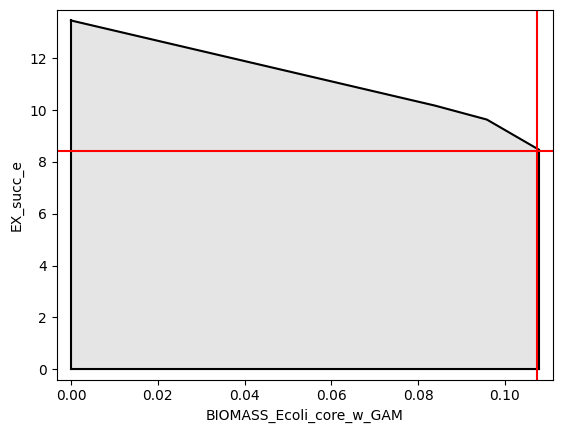

In [51]:
from mewpy.visualization.envelope import plot_flux_envelope
plot_flux_envelope(sim,BIOMASS,PRODUCT,constraints = solution.constraints)

# importing library
import matplotlib.pyplot as plt
  
# specifying horizontal line type
plt.axhline(y = 8.412776, color = 'r', linestyle = '-')
plt.axvline(x = 0.107462, color = 'r', linestyle = '-')

# rendering the plot
plt.show()

## Optimization Problem

In [62]:
# load the model
#from reframed.io.sbml import load_cbmodel
#model = load_cbmodel('iJO1366SL.xml', flavor='cobra')

# Define the target
#PRODUCT_ID = 'R_EX_tyr_DASH_L_LPAREN_e_RPAREN_'
#BIOMASS_ID = 'R_Ec_biomass_iJO1366_core_53p95M'

BIOMASS_ID = 'BIOMASS_Ecoli_core_w_GAM'
PRODUCT_ID = 'EX_succ_e'
#O2 = 'EX_o2_e'
#GLC = 'EX_glc__D_e'

# environmental conditions
#envcond = {'R_EX_o2_LPAREN_e_RPAREN_'  : (-9.66, 100000.0),
#           'R_EX_glc_LPAREN_e_RPAREN_' : (-12.5,100000.0)}

envcond = anaerobic

# Optimization objectives
from mewpy.optimization.evaluation import  BPCY, WYIELD
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method='lMOMA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

In [63]:
from mewpy.problems import ROUProblem
problem = ROUProblem(model, 
               fevaluation=[evaluator_1, evaluator_2], 
               envcond=envcond)

In [66]:
# run the optimization
from mewpy.optimization import EA
ea = EA(problem, max_generations= 100)
final_pop = ea.run()

Running NSGAII
Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  -0.000000  0.842784  0.000000  0.008831  0.083868|  0.000000  5.830126  0.000000  0.105063  0.639129|
    200|  -0.000000  0.842784  0.000000  0.011064  0.084870|  0.000000  5.830126  0.051864  0.232690  0.851600|
    300|  -0.000000  0.842784  0.000000  0.028260  0.122760|  0.016080  5.830126  0.066885  0.785476  1.424050|
    400|  -0.000000  0.842784  0.000432  0.086457  0.205137|  0.000000  7.489273  0.567490  1.889727  1.914397|
    500|  -0.000000  0.853981  0.032807  0.228628  0.313353|  0.262920  149.921184  3.517183  5.151748  14.645973|
    600|  -0.000000  0.853981  0.491410  0.490368  0.344996|  2.181884  153.318001  5.827167  13.613638  34.621854|
    700|  0.000000  1.050701  0.842200  0.608185  0.293379|  5.827167  153.318001  5.963180  17.978348  39.168540|
    800|  0.000000  396.629180  0.842784  6.962069  45.613395|  5.685929  154.12

In [67]:
final_pop1 = final_pop[0]

In [68]:
final_pop1.constraints

{'EX_for_e': (0, 0),
 'EX_h_e': (977.7349845627958, 10000),
 'ACONTa': (7.307621007021649, 10000),
 'ACt2r': (-10000, -136.05736444738312),
 'EX_glc__D_e': (-10000, -20.0),
 'ICDHyr': (0, 0.11418157823471328)}